In today's hands-on lecture, we will learn one non-learning based segmentation method (Watershed algorithm) and two learning based method for 2D/3D segmentation tasks separately.


# Segmentation
Segmentation is a technique used to partition an image into multiple segments or regions based on certain characteristics such as color, intensity, texture, etc. It can be used for various tasks such as medical imaging and autonomous driving.

# Watershed method

Any grayscale image can be viewed as a topographic surface where high intensity denotes peaks and hills while low intensity denotes valleys. You start filling every isolated valleys (local minima) with different colored water (labels). As the water rises, depending on the peaks (gradients) nearby, water from different valleys, obviously with different colors will start to merge. To avoid that, you build barriers in the locations where water merges. You continue the work of filling water and building barriers until all the peaks are under water. Then the barriers you created gives you the segmentation result.

Topograhic surface filled with water (animation):

![](http://www.cmm.mines-paristech.fr/~beucher/lpe1.gif)

In [1]:
# Download test image
!wget --no-check-certificate \
    https://johnloomis.org/ece563/notes/BinaryImages/coins/coins3.jpg \
    -O test.jpg

--2024-04-29 12:46:35--  https://johnloomis.org/ece563/notes/BinaryImages/coins/coins3.jpg
Resolving johnloomis.org (johnloomis.org)... 192.124.249.90
Connecting to johnloomis.org (johnloomis.org)|192.124.249.90|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16159 (16K) [image/jpeg]
Saving to: 'test.jpg'

test.jpg            100%[===================>]  15.78K  --.-KB/s    in 0.01s   

2024-04-29 12:46:36 (1.59 MB/s) - 'test.jpg' saved [16159/16159]



In [2]:
# import the necessary packages
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
import numpy as np
import imutils
import cv2
# from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt

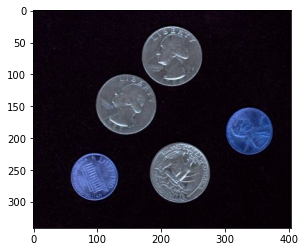

In [3]:
# load the image
image = cv2.imread("test.jpg")
plt.imshow(image)

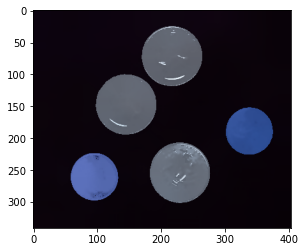

In [4]:
# filter out the unrelated features (the textures of the coin surface) for better segmentation performance
shifted = cv2.pyrMeanShiftFiltering(image, 21, 51) #by replacing each pixel value with the mean values of a range-r neighborhood#
plt.imshow(shifted)

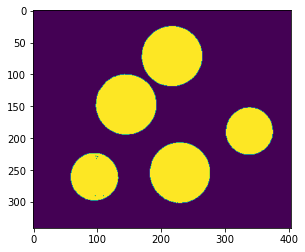

In [5]:
# convert the mean shift image to grayscale, then apply
# Otsu's thresholding, simply separate pixels into two classes, foreground and background.
gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255,
	cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
plt.imshow(thresh)

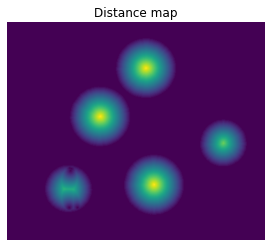

In [8]:
# For using the watershed algorithm, we need to find peaks of the topographic map.
# fisrt we need to build the distance map by computing the Euclidean Distance to the closest zero (i.e., background pixel)
# for each of the foreground pixels.


### find the function in ndimage module that does the distance transform


from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.set_axis_off()
D = ndimage.distance_transform_edt(thresh)
ax.imshow(D)
ax.set_title('Distance map')
plt.show()

In [9]:
# perform a connected component analysis on the local peaks,
# then appy the Watershed algorithm
localMax = peak_local_max(D, indices=False, min_distance=20, labels=thresh)
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0] #label the peaks as markers#
labels = watershed(-D, markers, mask=thresh)
print("{} unique segments found".format(len(np.unique(labels)) - 1))

5 unique segments found


we totally find 5 segments which are 5 coins with different size.

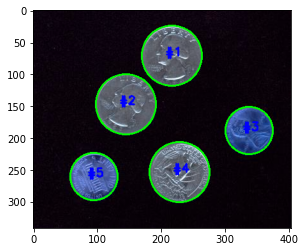

In [10]:
# then we just need to assign each pixel with different labels found by watershed method
# we will loop each unique labels
for label in np.unique(labels):
	# if the label is zero, we are examining the 'background'
	# so simply ignore it
	if label == 0:
		continue
	# otherwise, allocate memory for the label region and draw
	# it on the mask
	mask = np.zeros(gray.shape, dtype="uint8")
	mask[labels == label] = 255
	# detect contours in the mask and grab the largest one
	cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
		cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)
	# draw a circle enclosing the object which have the same labels
	((x, y), r) = cv2.minEnclosingCircle(c)
	cv2.circle(image, (int(x), int(y)), int(r), (0, 255, 0), 2)
	cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)),
		cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
# show the output image
plt.imshow(image)

# 2D image segmentation via deep neural networks (UNet) [Paper](https://arxiv.org/pdf/1505.04597.pdf)

In this section, we will use a pre-trained Unet model to do segmentation task on a 2D car image dataset.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)


U-net architecture (example for 32x32 pixels in the lowest resolution). Each blue box corresponds to a multi-channel feature map. The number of channels is denoted on top of the box. The x-y-size is provided at the lower left edge of the box. White boxes represent copied feature maps. The arrows denote the different operations.
The trained segmentation model will output a multi-channel segmentation maps as showed below. The number of channels is equal to the number of classes. The goal of 2D image segementation task is to label each pixel of the image with its corresponding classes.   

## Input image
![](https://raw.githubusercontent.com/divamgupta/image-segmentation-keras/master/sample_images/1_input.jpg)
## Output segmentation map
![](https://raw.githubusercontent.com/divamgupta/image-segmentation-keras/master/sample_images/1_output.png)



In [ ]:
%cd /content
!git clone https://github.com/johschmidt42/PyTorch-2D-3D-UNet-Tutorial.git

In [12]:
import sys

In [13]:
sys.path.append('/content/PyTorch-2D-3D-UNet-Tutorial')

In [1]:
import pathlib
import torch
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from matplotlib import pyplot as plt
from inference import predict
from transformations import normalize_01, re_normalize
from unet import UNet

ImportError: cannot import name 'predict' from 'inference' (/Users/mbp/opt/anaconda3/lib/python3.9/site-packages/inference/__init__.py)

In [ ]:
root = pathlib.Path.cwd() /'PyTorch-2D-3D-UNet-Tutorial' /'Carvana' / 'Test'

def get_filenames_of_path(path: pathlib.Path, ext: str = '*'):
    """Returns a list of files in a directory/path. Uses pathlib."""
    filenames = [file for file in path.glob(ext) if file.is_file()]
    return filenames

# input and target files
images_names = get_filenames_of_path(root / 'Input')
targets_names = get_filenames_of_path(root / 'Target')

# read images and store them in memory
images = [imread(img_name) for img_name in images_names]
targets = [imread(tar_name) for tar_name in targets_names]

# raw data images have different shapes, So we need to
# resize images and targets, resize the images to suitable shape and make them consistent
images_res = [resize(img, (128, 128, 3)) for img in images]
resize_kwargs = {'order': 0, 'anti_aliasing': False, 'preserve_range': True}
targets_res = [resize(tar, (128, 128), **resize_kwargs) for tar in targets]

In [ ]:
# device
if torch.cuda.is_available():
    ### set the device to use GPU using pytorch
    device = torch.device('cuda')
else:
    ### set the device to use CPU using pytorch
    device = torch.device('cpu')

# model
model = UNet(in_channels=3,
             out_channels=2,
             n_blocks=4,
             start_filters=32,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2).to(device)
# load pretrained model weights
model_name = 'carvana_model.pt'
model_weights = torch.load(pathlib.Path.cwd()/'PyTorch-2D-3D-UNet-Tutorial'/ model_name)

### set the weights of our model to above model_weights
model.load_state_dict(model_weights)

<All keys matched successfully>

In [ ]:
# preprocess function
def preprocess(img: np.ndarray):
    img = np.moveaxis(img, -1, 0)  # from [H, W, C] to [C, H, W]
    img = normalize_01(img)  # linear scaling to range [0-1]
    ### numpy function add an extra dimension
    img = np.expand_dims(img, axis=0)
    # add batch dimension [B, C, H, W]
    img = img.astype(np.float32)  # typecasting to float32
    return img

# postprocess function
def postprocess(img: torch.tensor):
    img = torch.argmax(img, dim=1)  # perform argmax to generate 1 channel
    img = img.cpu().numpy()  # send to cpu and transform to numpy.ndarray
    ### numpy function to remove the extra dimension we added before
    img = np.squeeze(img, axis=0)
    # remove batch dim and channel dim -> [H, W]
    img = re_normalize(img)  # scale it to the range [0-255]
    return img

In [ ]:
output = [predict(img, model, preprocess, postprocess, device) for img in images_res]

/usr/local/lib/python3.10/dist-packages/skimage/util/dtype.py:541: UserWarning: Downcasting int64 to uint8 without scaling because max value 1 fits in uint8
  return _convert(image, np.uint8, force_copy)


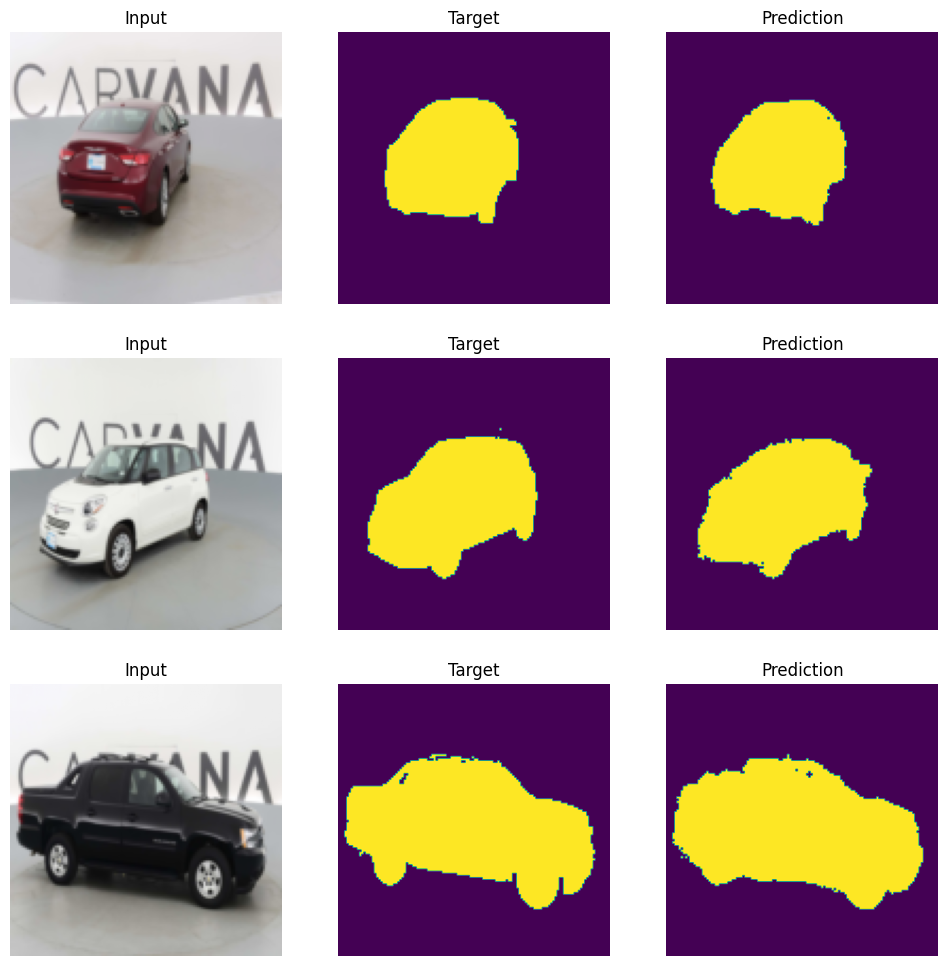

In [ ]:
row=len(images_res)
fig=plt.figure(figsize=(12, 12))
for i in range(row):
  fig.add_subplot(row, 3, 3*i+1)
  plt.imshow(images_res[i])
  plt.title("Input")
  plt.axis('off')
  fig.add_subplot(row, 3, 3*i+2)
  plt.imshow(targets_res[i])
  plt.title("Target")
  plt.axis('off')
  fig.add_subplot(row, 3, 3*i+3)
  plt.imshow(output[i])
  plt.title("Prediction")
  plt.axis('off')
plt.show()

# 3D point cloud segmentation via deep neural networks. [PointNet](https://arxiv.org/pdf/1612.00593.pdf)

In this section, we will use a pre-trained PointNet model to do segmentation task on the 3D pointcloud dataset. We will use "Chair" and "Airplane" as examples.

##Pointnet architecture:
Originally, this model is designed for both classification and segmentation tasks. The input data will be a pointcloud consists of n points. Then, several feature transformations layers are applied to gradually convert the input data to a high diemension feature space. Next, point features will be aggregated by max pooling (global feature). It makes the model permutation invariant of the input data. The output is classification scores for k classes. The segmentation network is an extension to the classification net. It concatenates global and local features and outputs labels for each points.   

![](http://stanford.edu/~rqi/pointnet/images/pointnet.jpg)

Input data will be a group of points (pointcloud) without any label. Here we will learn the part segmentation which will group each point to different parts of the original model. For example, the input airplane pointcloud will be segmented as wings, rear, engine, and body.    

![](http://stanford.edu/~rqi/pointnet/images/teaser.jpg)

In [ ]:
%cd /content
!git clone https://github.com/WenyuHan-LiNa/pointcloud_segment.git

/content
Cloning into 'pointcloud_segment'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 29 (delta 4), reused 20 (delta 1), pack-reused 0
Receiving objects: 100% (29/29), 23.86 MiB | 27.00 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [ ]:
%cd /content/pointcloud_segment/
!pip install -e.

/content/pointcloud_segment
Obtaining file:///content/pointcloud_segment
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_

In [ ]:
%cd /content/pointcloud_segment/

/content/pointcloud_segment


In [ ]:
from __future__ import print_function
import numpy as np
import torch
import torch.nn.parallel
import torch.utils.data
from torch.autograd import Variable
from pointnet.dataset import ShapeNetDataset
from pointnet.model import PointNetDenseCls
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
!wget --no-check-certificate "https://shapenet.cs.stanford.edu/ericyi/shapenetcore_partanno_segmentation_benchmark_v0.zip" -O "shapenetcore_partanno_segmentation_benchmark_v0.zip"

--2024-04-24 17:12:29--  https://shapenet.cs.stanford.edu/ericyi/shapenetcore_partanno_segmentation_benchmark_v0.zip
Resolving shapenet.cs.stanford.edu (shapenet.cs.stanford.edu)... 171.67.77.19
Connecting to shapenet.cs.stanford.edu (shapenet.cs.stanford.edu)|171.67.77.19|:443... connected.
  Issued certificate has expired.
HTTP request sent, awaiting response... 200 OK
Length: 666265910 (635M) [application/zip]
Saving to: ‘shapenetcore_partanno_segmentation_benchmark_v0.zip’

shapenetcore_partan 100%[===================>] 635.40M  7.39MB/s    in 68s     

2024-04-24 17:13:37 (9.37 MB/s) - ‘shapenetcore_partanno_segmentation_benchmark_v0.zip’ saved [666265910/666265910]



In [ ]:
!unzip "/content/pointcloud_segment/shapenetcore_partanno_segmentation_benchmark_v0.zip" -d "./"

Streaming output truncated to the last 5000 lines.
  inflating: ./shapenetcore_partanno_segmentation_benchmark_v0/02691156/seg_img/e1225308d6c26c862b600da24e0965.png  
  inflating: ./shapenetcore_partanno_segmentation_benchmark_v0/02691156/seg_img/46ae88cad17edca7ae7c0d0e12bd33da.png  
  inflating: ./shapenetcore_partanno_segmentation_benchmark_v0/02691156/seg_img/1ea7a36e4f353416fe1f6e05091d5d9.png  
  inflating: ./shapenetcore_partanno_segmentation_benchmark_v0/02691156/seg_img/e94ad5f8e53a255a8fc2d09ac4aa4e78.png  
  inflating: ./shapenetcore_partanno_segmentation_benchmark_v0/02691156/seg_img/8b61ba80d9e487deca8607f540cc62ba.png  
  inflating: ./shapenetcore_partanno_segmentation_benchmark_v0/02691156/seg_img/3cbc83ba49edeccebc0909d98a1ff2b4.png  
  inflating: ./shapenetcore_partanno_segmentation_benchmark_v0/02691156/seg_img/c5d0dd7a7b44b079a76ffc04f04676cb.png  
  inflating: ./shapenetcore_partanno_segmentation_benchmark_v0/02691156/seg_img/75db11c354c6342aad01ec966c80ac91.png  


In [ ]:
data_dir="/content/pointcloud_segment/shapenetcore_partanno_segmentation_benchmark_v0/"
class_choice="Chair"
model_dir="/content/pointcloud_segment/pretrianed_model/seg_model_Chair_1.pth"

In [ ]:
d = ShapeNetDataset(
    root=data_dir,
    class_choice=class_choice,
    split='test',
    data_augmentation=False)

# Testing on the Chair datset

In [ ]:
# choose one of the model from testing data

idx = 0 ## you can easily change to others
print("model %d/%d" % (idx, len(d)))
point, seg = d[idx]
print(point.size(), seg.size())
point_np = point.numpy()


### load pre-trained model
state_dict = torch.load(model_dir)
print(state_dict['conv4.weight'].size()[0])

classifier = PointNetDenseCls(k= state_dict['conv4.weight'].size()[0])
classifier.load_state_dict(state_dict)
classifier.eval()

point = point.transpose(1, 0).contiguous()

point = Variable(point.view(1, point.size()[0], point.size()[1]))
pred, _, _ = classifier(point)
pred_choice = pred.data.max(2)[1]
print(pred_choice)
print(pred_choice.shape)
#print(pred_choice.size())
pred_color = pred_choice.numpy()[0]

print(pred_color.shape)

model 0/704
torch.Size([2500, 3]) torch.Size([2500])
4
tensor([[0, 1, 1,  ..., 1, 0, 0]])
torch.Size([1, 2500])
(2500,)


In [ ]:
x,y,z=point_np.T
#colab does not support matplotlib interactive window we normally used in the jupyter notebook, so here we use plotly for visualizing our results#

fig = make_subplots(
    rows=1, cols=3,
    specs=[[{"type": "scatter3d"}, {"type": "scatter3d"},{"type": "scatter3d"}]],
    subplot_titles=("Input","Groundtruth part segmentation", "predicted part segmentation")
)

fig.add_trace(go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        color=1,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=1
    )
),row=1, col=1)

fig.add_trace(go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        color=seg,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=1
    )
),row=1, col=2)

fig.add_trace(go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        color=pred_color,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=1
    )
),row=1, col=3)
fig.update_layout(showlegend=False)
fig.update_traces(marker=dict(size=3,line=dict(width=2,color='DarkSlateGrey')),selector=dict(mode='markers'))

From this result, we can see that this model perform pretty well on this part segmentation task. it can generally group each points to seat, back, and legs. However, the shortcoming of this model is that, the points at the intersection area cannot be grouped well. it is due the information loss when using the maxpooling. Detailed could be found in the paper. The following works, like PointNet++ learns features in the hierarchical way. They extract features from differnent scales (from small range to large). The features extracted from small range can caputre more local information than PointNet. Then aggragate these features to output the semantic labels.

# Tesing on the airplane dataset by using pretrained model on the chair dataset





In [ ]:
data_dir="/content/pointcloud_segment/shapenetcore_partanno_segmentation_benchmark_v0"
class_choice="Airplane"
model_dir="/content/pointcloud_segment/pretrianed_model/seg_model_Chair_1.pth"

In [ ]:
d = ShapeNetDataset(
    root=data_dir,
    class_choice=class_choice,
    split='test',
    data_augmentation=False)

In [ ]:
idx = 0

print("model %d/%d" % (idx, len(d)))
point, seg = d[idx]
print(point.size(), seg.size())
point_np = point.numpy()


### load pre-trained model
state_dict = torch.load(model_dir)
print(state_dict['conv4.weight'].size()[0])

classifier = PointNetDenseCls(k= state_dict['conv4.weight'].size()[0])
classifier.load_state_dict(state_dict)
classifier.eval()

point = point.transpose(1, 0).contiguous()

point = Variable(point.view(1, point.size()[0], point.size()[1]))
pred, _, _ = classifier(point)
pred_choice = pred.data.max(2)[1]
print(pred_choice)
print(pred_choice.shape)
#print(pred_choice.size())
pred_color = pred_choice.numpy()[0]

print(pred_color.shape)

model 0/341
torch.Size([2500, 3]) torch.Size([2500])
4
tensor([[1, 1, 1,  ..., 1, 1, 1]])
torch.Size([1, 2500])
(2500,)


In [ ]:
x,y,z=point_np.T
fig = make_subplots(
    rows=1, cols=3,
    specs=[[{"type": "scatter3d"}, {"type": "scatter3d"},{"type": "scatter3d"}]],
    subplot_titles=("Input","Groundtruth part segmentation", "predicted part segmentation")
)

fig.add_trace(go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        color=1,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=1
    )
),row=1, col=1)

fig.add_trace(go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        color=seg,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=1
    )
),row=1, col=2)

fig.add_trace(go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        color=pred_color,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=1
    )
),row=1, col=3)
fig.update_layout(showlegend=False)
fig.update_traces(marker=dict(size=3,line=dict(width=2,color='DarkSlateGrey')),selector=dict(mode='markers'))

# Tesing on the airplane dataset by using pretrained model on the airplane dataset


In [ ]:
data_dir="/content/pointcloud_segment/shapenetcore_partanno_segmentation_benchmark_v0"
class_choice="Airplane"
model_dir="/content/pointcloud_segment/pretrianed_model/seg_model_Airplane_4.pth"

In [ ]:
idx = 0

print("model %d/%d" % (idx, len(d)))
point, seg = d[idx]
print(point.size(), seg.size())
point_np = point.numpy()


### load pre-trained model
state_dict = torch.load(model_dir)
print(state_dict['conv4.weight'].size()[0])

classifier = PointNetDenseCls(k= state_dict['conv4.weight'].size()[0])
classifier.load_state_dict(state_dict)
classifier.eval()

point = point.transpose(1, 0).contiguous()

point = Variable(point.view(1, point.size()[0], point.size()[1]))
pred, _, _ = classifier(point)
pred_choice = pred.data.max(2)[1]
print(pred_choice)
print(pred_choice.shape)
#print(pred_choice.size())
pred_color = pred_choice.numpy()[0]

print(pred_color.shape)
x,y,z=point_np.T
fig = make_subplots(
    rows=1, cols=3,
    specs=[[{"type": "scatter3d"}, {"type": "scatter3d"},{"type": "scatter3d"}]],
    subplot_titles=("Input","Groundtruth part segmentation", "predicted part segmentation")
)

fig.add_trace(go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        color=1,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=1
    )
),row=1, col=1)

fig.add_trace(go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        color=seg,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=1
    )
),row=1, col=2)

fig.add_trace(go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        color=pred_color,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=1
    )
),row=1, col=3)
fig.update_layout(showlegend=False)
fig.update_traces(marker=dict(size=3,line=dict(width=2,color='DarkSlateGrey')),selector=dict(mode='markers'))

model 0/341
torch.Size([2500, 3]) torch.Size([2500])
4
tensor([[3, 3, 3,  ..., 1, 0, 3]])
torch.Size([1, 2500])
(2500,)


This model works well when it is trained and tested on the data with same category. However, it has poor generalization ability across the categories. Trained on chair and test on the airplane dataset.

# Homework 11

In this homework, you will use the UNet model to segment ```test.jpg ``` and ```water_coins.jpg``` images.
Upload the output segmentation images for both the images and explain why the output looks the way it does.

Upload your images and enter the answers to the [HW11 Google Form](https://forms.gle/1cLXyxFKBfqidxQi9)
  